In [1]:
import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 6: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## Adversarial noise for MNIST

##### Based on the notebook found here
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/12_Adversarial_Noise_MNIST.ipynb

##### Intro Write-up

In [2]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [3]:
# Load the dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

## Plotting MNIST images with true labels

In [11]:
# A function to plot images, taking a list of images, the number of rows and cols
def plot_images(images, row, col, true_labels=None, false_labels=None):
    
    # Creating a figure of subplots
    fig, axes = plt.subplots(row, col)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        image = images[i].reshape((28, 28))
        
        ax.imshow(image, cmap='gray')
        
        if true_labels != None:
            ax.set_xlabel("True: {}, Pred: {}".format(true_labels[i], false_labels[i]))
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Show cells
    plt.show()

/home/schiang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


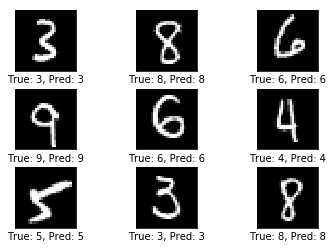

In [12]:
plot_images(X_val[0:9], 3, 3, y_val[:9], y_val[:9])

# Building and training an MNIST network

#### From MNIST-lasagne notebook

In [38]:
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform('relu'))
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify)
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [39]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [40]:
# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
# Create neural network model
network = build_cnn(input_var)

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

#Theano functions for training and testing
train_fn = theano.function([input_var, target_var], loss, updates=updates)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [41]:
num_epochs=15

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 15 took 1.064s
  training loss:		1.596552
  validation loss:		0.356259
  validation accuracy:		90.67 %
Epoch 2 of 15 took 1.040s
  training loss:		0.502706
  validation loss:		0.176895
  validation accuracy:		95.30 %
Epoch 3 of 15 took 1.044s
  training loss:		0.341954
  validation loss:		0.130727
  validation accuracy:		96.34 %
Epoch 4 of 15 took 1.044s
  training loss:		0.268094
  validation loss:		0.114000
  validation accuracy:		96.54 %
Epoch 5 of 15 took 1.043s
  training loss:		0.235851
  validation loss:		0.096249
  validation accuracy:		97.24 %
Epoch 6 of 15 took 1.042s
  training loss:		0.209152
  validation loss:		0.087313
  validation accuracy:		97.47 %
Epoch 7 of 15 took 1.036s
  training loss:		0.191421
  validation loss:		0.080369
  validation accuracy:		97.70 %
Epoch 8 of 15 took 1.042s
  training loss:		0.179608
  validation loss:		0.075056
  validation accuracy:		97.80 %
Epoch 9 of 15 took 1.034s
  training loss:		0.165215
  validation loss:		0.070504
  vali

# Working with Adversarial Noise

Following the work from a notebook tutorial created by the Hvass lab, I am trying to generate a noise matrix that is able to generate adversarial noise to confuse the digits 2 and 6. The idea is to begin with a trained CNN for MNIST classification, and then a 28x28 matrix of random noise. Then the input is chosen to be the image added with the noise and fed into the CNN. THe cost function is then generated, but instead of using the actual prediction, you choose a mis-classified label and backpropagate the resulting function to modify the noise. Doing so over several iterations should produce noise patterns that are able to disrupt regular classification of digits. 

In [42]:
#Saving parameters from trained network
trained_params = lasagne.layers.get_all_params(network)

In [200]:
# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
noise_values = np.zeros((1, 28, 28), dtype=theano.config.floatX)
noise = theano.shared(noise_values, borrow=True, name='noise')

l2_weight = 0.01
noise_clip = 0.35

noisy_image = noise.clip(-noise_clip, noise_clip) + input_var
ad_network = build_cnn(noisy_image)
lasagne.layers.set_all_param_values(ad_network, extracted)

prediction = lasagne.layers.get_output(ad_network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
loss += lasagne.regularization.l2(noise) * l2_weight #adding l2 regularization

#params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, [noise], learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(ad_network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

#Theano functions for training and testing
train_fn = theano.function([input_var, target_var], loss, updates=updates)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [53]:
mistargets = np.array([6 for i in range(500)]).astype('uint8')

In [188]:
print type(mistargets[0])
print type(y_train[0])

<type 'numpy.uint8'>
<type 'numpy.uint8'>


In [201]:
num_epochs=50
#noise = theano.shared(noise_values, borrow=True, name='noise')

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs.clip(0, 1), mistargets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs.clip(0, 1), mistargets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 50 took 0.914s
  training loss:		5.342086
  validation loss:		1.555510
  validation accuracy:		57.62 %
Epoch 2 of 50 took 0.881s
  training loss:		2.140875
  validation loss:		0.947866
  validation accuracy:		70.73 %
Epoch 3 of 50 took 0.885s
  training loss:		1.808965
  validation loss:		0.780418
  validation accuracy:		74.87 %
Epoch 4 of 50 took 0.880s
  training loss:		1.702336
  validation loss:		0.710155
  validation accuracy:		76.95 %
Epoch 5 of 50 took 0.879s
  training loss:		1.656930
  validation loss:		0.670672
  validation accuracy:		78.16 %
Epoch 6 of 50 took 0.884s
  training loss:		1.643428
  validation loss:		0.644676
  validation accuracy:		78.83 %
Epoch 7 of 50 took 0.879s
  training loss:		1.616299
  validation loss:		0.626347
  validation accuracy:		79.37 %
Epoch 8 of 50 took 0.880s
  training loss:		1.609858
  validation loss:		0.614854
  validation accuracy:		79.69 %
Epoch 9 of 50 took 0.885s
  training loss:		1.592193
  validation loss:		0.607286
  vali

## Plot of the adversarial noise

In [203]:
print(np.max(noise.eval()))
print(np.min(noise.eval()))

0.352071
-0.352366


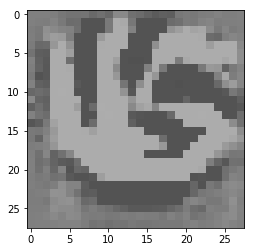

In [209]:
plt.imshow(noise.eval().reshape((28, 28)), cmap='gray', vmin=-1, vmax=1)

## Adversarial noise added to the image

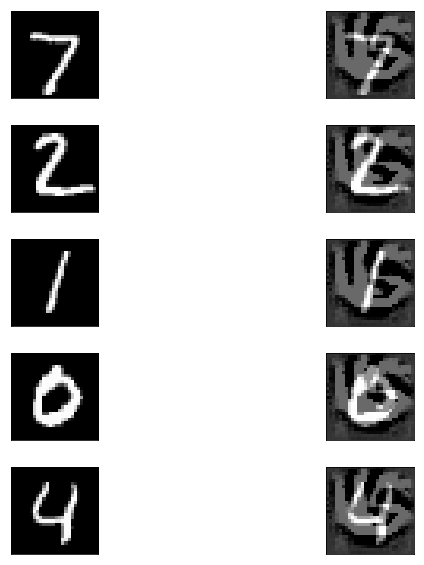

In [211]:
# Creating a figure of subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(5):

    image = X_test[i].reshape((28, 28))

    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 1].imshow(image + np.array(noise.eval()).squeeze(), cmap='gray')

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# Show cells
plt.show()

### Comparing the original trained MNIST CNN with regular digits and with the adversarial noise

In [128]:
extracted = []
for p in trained_params:
    extracted.append(p.eval())

In [133]:
input_var = T.tensor4('inputs')

network = build_cnn(input_var)
lasagne.layers.set_all_param_values(network, extracted)

test_prediction = lasagne.layers.get_output(network)
output_fn = theano.function([input_var], T.argmax(test_prediction, axis=1))

inputs, targets = batch
pred = output_fn(X_test)

### Plotting the original predictions again

/home/schiang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


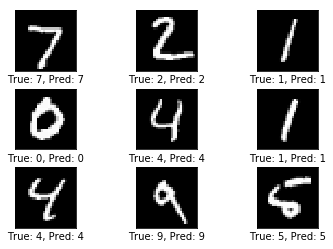

In [140]:
plot_images(X_test[0:9], 3, 3, pred[:9], pred[:9])

### Plotting the images with added "random noise"

Because the images with adversarial noise do look different than the original MNIST images (presumably because the MNIST images are noise free initially and would be different with natural images).

In [156]:
import copy

In [157]:
X_test_noise = copy.deepcopy(X_test)

In [168]:
X_test_noise = np.random.normal(X_test_noise, 0.35)

In [172]:
X_test_noise = X_test_noise.astype('float32')

In [173]:
pred = output_fn(X_test_noise)

In [182]:
# Outputting the accuracy of the predictions after noise corruption
accuracy = np.sum(pred == y_test) / 10000.0
print "The accuracy of the MNIST plus random noise is {}".format(accuracy * 100)

The accuracy of the MNIST plus random noise is 95.52


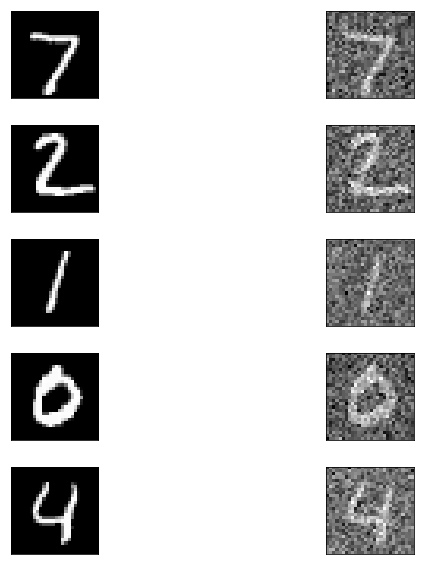

In [175]:
# Creating a figure of subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(5):

    axes[i, 0].imshow(X_test[i].reshape((28, 28)), cmap='gray')
    axes[i, 1].imshow(X_test_noise[i].reshape((28, 28)), cmap='gray')

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# Show cells
plt.show()

## Plotting the images with the adversarial noise

In [177]:
X_test_ad = copy.deepcopy(X_test)
X_test_ad += noise.eval()

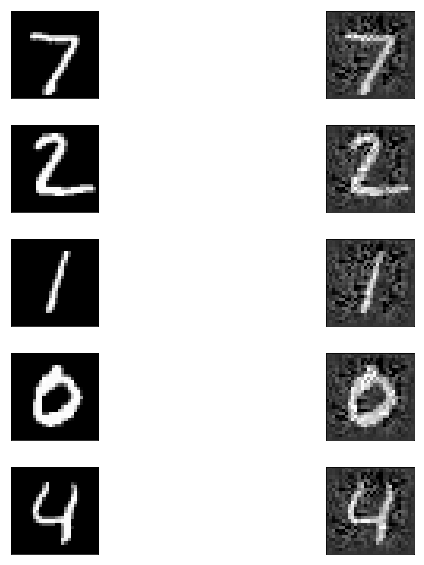

In [178]:
# Creating a figure of subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(5):

    axes[i, 0].imshow(X_test[i].reshape((28, 28)), cmap='gray')
    axes[i, 1].imshow(X_test_ad[i].reshape((28, 28)), cmap='gray')

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# Show cells
plt.show()

In [221]:
noise_constant = np.array(noise.eval()) * 0.75
pred = output_fn(X_train + noise_constant)
accuracy = np.sum(pred == y_train) / 50000.0

print "The accuracy of the MNIST plus adversarial noise is {}".format(accuracy * 100)

The accuracy of the MNIST plus adversarial noise is 50.502


In [223]:
noise_constant = np.array(noise.eval()) * 0.75
pred = output_fn(X_test + noise_constant)
accuracy = np.sum(pred == y_test) / 10000.0

print "The accuracy of the MNIST plus adversarial noise is {}".format(accuracy * 100)

The accuracy of the MNIST plus adversarial noise is 52.48


/home/schiang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


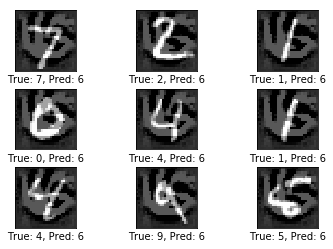

In [224]:
plot_images(X_test[0:9] + noise_constant, 3, 3, y_test[:9], [6 for i in range(9)])

## So at this point, we've added some noise to an image that is able to modify the input image such that misclassification to a 6 label is far more common than any other classification